# Exploring Foundation Reviews on Sephora

Do you wear makeup? If you do, you may know that foundation is foundamental (no pun intended!) when putting on makeup. And you may already know that picking the right foundation involves a lot of considerations. Many people go to retailer's websites like [Ulta](https://www.ulta.com/) or [Sephora](https://www.sephora.com/) to check on reviews. I use `selenium` to collect 120K reviews for 102 foundations from 39 brands on [Sephora](https://www.sephora.com/).

The key insights from this dataset are:

+ Most of the reviewers (87% of them) on Sephora only give out 1 review (100K reviewers with 120K reviews)
+ When people leave a review, it is usually when they really like the product (more than half of the reviews have 5-star ratings)
+ When people give out a 5-star rating for a foundation, they are mostly pleased by the coverage of the foundation (46% of the 5-star reviews mention coverage)
+ Most people who give out reviews on Sephora are brown-eyed, light-skin brunettes
+ These people tend to have different preferences about foundations compared to the rest of the revieweres

In [1]:
# hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
from tqdm import tqdm
import os
import scipy.stats as st
from datetime import datetime

from IPython.display import display_html, HTML
from functools import reduce
import operator
import random

pd.options.display.max_rows = 200
pd.options.display.float_format = "{:,.2f}".format

In [8]:
# hide
def plot_countbar(data, col1):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=data[col1], order=data[col1].value_counts().index)
    # plt.xticks(rotation=90)
    plt.xlabel(f'{col1} given by reviewers')
    # plt.title(label.replace('_', ' '))

def plot_cross_tab_heatmap(data: pd.DataFrame, product: str, col1: str, col2: str, col3: str, func: str = 'mean'):
    """
    given a product, cross-tabulate col1 and col2 in data, and create a heatmap given func with col3 as the color bar
    col1
        categorical data in x axis
    col2
        categorical data in y axis
    col3
        continuous data in color bar
    func
        'mean' or 'median' for aggfunc in pd.crosstab
    """
    col1_col2_crosstab = pd.crosstab(data[col1], data[col2], values=data[col3], aggfunc=func)
    col1_labels = data.groupby(col1, as_index=False).count()[col1]
    col2_labels = data.groupby(col2, as_index=False).count()[col2]

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(col1_col2_crosstab)
    ax.set_yticks(np.arange(len(col1_labels)), labels=col1_labels)
    ax.set_xticks(np.arange(len(col2_labels)), labels=col2_labels)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(col3, rotation=-90, va="bottom")

    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    # threshold = im.norm(col1_col2_crosstab.max())/2
    texts = []
    textcolors = ("black", "white")
    for i in range(col1_col2_crosstab.shape[0]):
        for j in range(col1_col2_crosstab.shape[1]):
            kw.update(color=textcolors[int(im.norm(col1_col2_crosstab.iloc[i, j]) < 0.5)])
            text = im.axes.text(j, i, round(col1_col2_crosstab.iloc[i, j], 2), kw)
            texts.append(text)
    plt.title(product.replace('_', ' '))
    plt.show()


def plot_diff_in_means(data: pd.DataFrame, col1: str, col2: str = 'rating', head: bool = True):
    """
    given a product, plots difference in means across groups and saves the figure
    col1
        categorical data with groups
    col2
        continuous data for the means
    """

    data_groupby = data.groupby(col1, as_index=False)[col2]
    data_groupby_labels = data_groupby.agg('mean').sort_values(col2, ascending=True)

    data_agg = pd.DataFrame(data_groupby_labels).rename(columns={col2: 'mean'})
    data_agg[col1] = data_agg[col1].replace('_','')
    n = data_groupby.count()
    data_agg = data_agg.merge(n, how='left', right_on=col1, left_on=col1).rename(columns={col2: 'n'})

    std = data_groupby.agg(np.std)
    data_agg = data_agg.merge(std, how='left', right_on=col1, left_on=col1).rename(columns={col2: 'std'})
    data_agg['se'] = data_agg['std'] / np.sqrt(data_agg['n'])

    data_agg['lower'] = st.t.interval(alpha=0.95, df=data_agg['n'] - 1, loc=data_agg['mean'], scale=data_agg['se'])[0]
    data_agg['upper'] = st.t.interval(alpha=0.95, df=data_agg['n'] - 1, loc=data_agg['mean'], scale=data_agg['se'])[1]

    if head:
        data_agg_head = data_agg[:5]
        n = list(data_agg_head[col1])
        for upper, mean, lower, y in zip(data_agg_head['upper'], data_agg_head['mean'], data_agg_head['lower'], data_agg_head[col1]):
            plt.plot((lower, mean, upper), (y, y, y), 'b.-')
        plt.yticks(range(len(n)), [i.replace('_', ' ') for i in list(data_agg_head[col1])])
    else:
        for upper, mean, lower, y in zip(data_agg['upper'], data_agg['mean'], data_agg['lower'], data_agg[col1]):
            plt.plot((lower, mean, upper), (y, y, y), 'b.-')
        plt.yticks(range(len(n)),  [i.replace('_', ' ') for i in list(data_agg[col1])])

def reformat_large_tick_values(tick_val, pos):
    """
    Credit for this function goes to https://github.com/jvanelteren for their post on https://github.com/jvanelteren/blog/blob/master/_notebooks/2022-01-19-boardgames.ipynb
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and
    also appropriately turns 4000 into 4K
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")

    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]

    return new_tick_format

def display_dfs_horiz(dfs, titles):
    """
    Credit for this function goes to https://github.com/jvanelteren for their post on https://github.com/jvanelteren/blog/blob/master/_notebooks/2022-01-19-boardgames.ipynb
    """
    htmls = []
    for i in range(len(dfs)):
        styler = dfs[i].style.set_table_attributes("style='display:inline'").set_caption(titles[i])
        htmls.append(styler._repr_html_())
    display_html(reduce(operator.add, htmls), raw=True)

In [3]:
# hide
# to get the data of foundations from directory
# the first dataset
all_data = pd.read_json('data_full_review_cleaned/Anastasia_Beverly_Hills_Stick_Foundation.json', lines=True)
all_data['brand_product'] = 'Anastasia_Beverly_Hills_Stick_Foundation'
for file in os.listdir('data_full_review_cleaned/'):
   if file.endswith(".json"):
      new_data = pd.read_json(f'data_full_review_cleaned/{file}', lines=True)
      new_data['brand_product'] = file.replace('.json', '')
      all_data = pd.concat([all_data, new_data])
all_data.reset_index(drop=True, inplace=True)

In [4]:
# adding foundation features: coverage and finish
foundation_features = pd.read_csv('foundation_features_parsed.csv')
all_data = pd.merge(all_data, foundation_features, on='brand_product', how='left')
for i in tqdm(range(len(all_data))):
    all_data.loc[i, 'date_of_review'] = datetime.fromtimestamp(all_data.loc[i, 'date_of_review']/1000)

100%|██████████| 121527/121527 [01:35<00:00, 1270.60it/s]


In [5]:
len(all_data)

121527

In [6]:
len(all_data['reviewer_id'].unique())

102144

## The reviewers and ratings

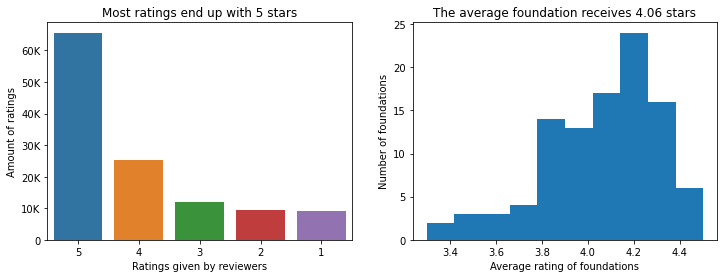

In [7]:
# hide_input
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=all_data['rating'], order=all_data['rating'].value_counts().index, ax=ax1)
ax1.set_xlabel('Ratings given by reviewers')
ax1.set_ylabel('Amount of ratings')
ax1.title.set_text('Most ratings end up with 5 stars')
ax1.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax2.hist(all_data.groupby(['brand_product']).mean()['rating'], bins=10)
ax2.set_xlabel('Average rating of foundations')
ax2.set_ylabel('Number of foundations')
ax2.title.set_text('The average foundation receives 4.06 stars')


Out of 5 stars, most users give out 5 stars. More than 60K reviews end up with 5 stars.

When looking at the average ratings across all foundations, we see the distribution skews to the right, and the average foundation receives 4.06 stars.

### Ratings & Whether 'Recommend' Or Not

In [21]:
pd.crosstab(all_data['rating'], all_data['recommended'],margins=True, normalize=True)

recommended,0,1,All
rating,,,
1,0.07,0.00,0.08
2,0.07,0.00,0.08
3,0.06,0.04,0.10
4,0.00,0.20,0.21
5,0.00,0.54,0.54
All,0.21,0.79,1.00


<AxesSubplot:xlabel='rating'>

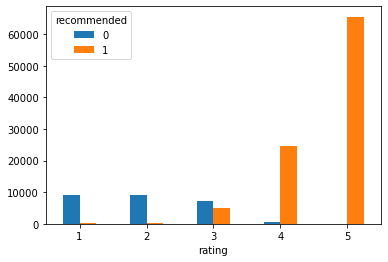

In [18]:
pd.crosstab(all_data['rating'], all_data['recommended'], normalize=False).plot.bar(rot=0)

In addition to rating, Sephora asks each reviewer whether they recommend the product or not in their reviews.

We can see that:

+ People who gave out 5-star reviews all said that they recommend the product
+ Less than 1% of those who gave 4 stars said they do not recommend the product
+ Almost half of those who rated the product with 3 stars said they recommend the product

### How Many Reviews Do People Give Out?

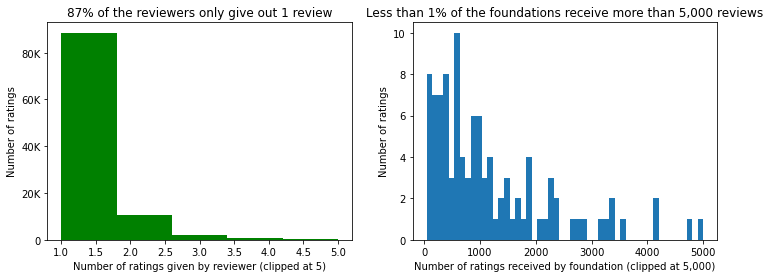

In [8]:
# hide_input
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# sns.countplot(x=all_data['rating'], order=all_data['rating'].value_counts().index, ax=ax1)
ax1.hist(all_data.groupby(['reviewer_id']).count()['rating'].clip(0,5), bins=5, color='green')
# sns.countplot(x=all_data.groupby(['reviewer_id']).count()['rating'],
              # order=sorted(all_data.groupby(['reviewer_id']).count()['rating'].value_counts().index), ax=ax1)
ax1.set_xlabel('Number of ratings given by reviewer (clipped at 5)')
ax1.set_ylabel('Number of ratings')
ax1.title.set_text('87% of the reviewers only give out 1 review')
ax1.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax2.hist(all_data.groupby(['brand_product']).count()['rating'].clip(0,5000), bins=50)#.plot.hist(ax=ax2)
ax2.set_xlabel('Number of ratings received by foundation (clipped at 5,000)')
ax2.set_ylabel('Number of ratings')
ax2.title.set_text('Less than 1% of the foundations receive more than 5,000 reviews')


+ 87% of the **reviewers** on Sephora only give out 1 review. Together they account for 73% of all reviews
+ 13% of the reviewers give out more than 2 reviews. Together they account for at least 23% of all reviews
+ Only 4 **foundations** receive >4,000 reviews, but these reviews account for at least 13% of all reviews
+ 58% of the foundations only have <1,000 reviews, and together they account for at most 48% of all reviews

In [22]:
# hide
(
    sum(all_data.groupby(['reviewer_id']).count()['rating']<2),
    sum(all_data.groupby(['reviewer_id']).count()['rating']<2) / len(all_data.groupby(['reviewer_id']).count()['rating']),
    sum(all_data.groupby(['reviewer_id']).count()['rating']<2) / len(all_data['rating']),
    sum(all_data.groupby(['reviewer_id']).count()['rating']>=2),
    sum(all_data.groupby(['reviewer_id']).count()['rating']>=2) / len(all_data.groupby(['reviewer_id']).count()['rating']),
    sum(all_data.groupby(['reviewer_id']).count()['rating']>=2) * 2 / len(all_data['rating'])
)


(88071,
 0.8622239191729323,
 0.7247031523858896,
 14073,
 0.13777608082706766,
 0.23160285368683503)

In [23]:
# hide
(
    sum(all_data.groupby(['brand_product']).count()['rating']<=1000),
    sum(all_data.groupby(['brand_product']).count()['rating']<=1000) / len(all_data.groupby(['brand_product']).count()['rating']),
    sum(all_data.groupby(['brand_product']).count()['rating']<=1000) * 1000 / len(all_data['rating']),
    sum(all_data.groupby(['brand_product']).count()['rating']>=4000) ,
    sum(all_data.groupby(['brand_product']).count()['rating']>=4000) / len(all_data.groupby(['brand_product']).count()['rating']),
    sum(all_data.groupby(['brand_product']).count()['rating']>=4000) * 4000 / len(all_data['rating'])

)


(58,
 0.5686274509803921,
 0.4772601973224057,
 4,
 0.0392156862745098,
 0.13165798546824986)

### Who are these reviewers?

Based on the self-reported characteristics from the 100K reviewers:

+ 26% of them have light skin tones
+ 55% have brown eyes
+ 49% have brunette hair

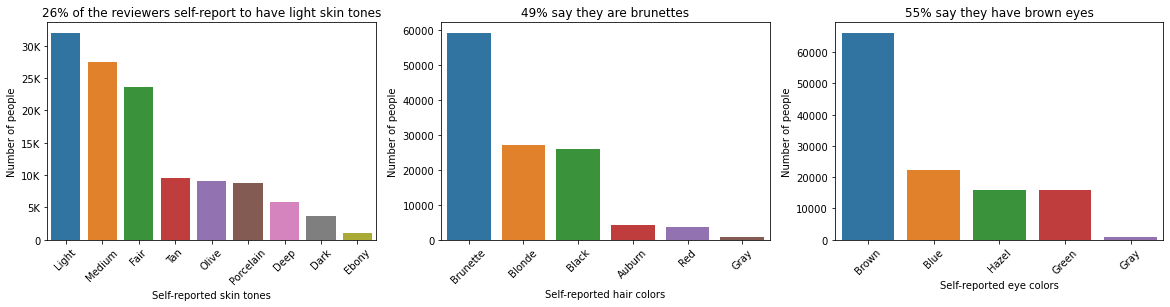

In [11]:
# hide_input
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
sns.countplot(x=all_data['skin_tone'], order=all_data['skin_tone'].value_counts().index, ax=ax1)
ax1.set_xlabel('Self-reported skin tones')
ax1.set_ylabel('Number of people')
ax1.title.set_text('26% of the reviewers self-report to have light skin tones')
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

sns.countplot(x=all_data['hair_color'], order=all_data['hair_color'].value_counts().index, ax=ax2)
ax2.set_xlabel('Self-reported hair colors')
ax2.set_ylabel('Number of people')
ax2.tick_params(axis='x', rotation=45)
ax2.title.set_text('49% say they are brunettes')

sns.countplot(x=all_data['eye_color'], order=all_data['eye_color'].value_counts().index, ax=ax3)
ax3.set_xlabel('Self-reported eye colors')
ax3.set_ylabel('Number of people')
ax3.tick_params(axis='x', rotation=45)
ax3.title.set_text('55% say they have brown eyes')


In [24]:
# hide
all_data.groupby('skin_tone').count()['reviewer_id'] / len(all_data)

skin_tone
Dark        0.03
Deep        0.05
Ebony       0.01
Fair        0.20
Light       0.26
Medium      0.23
Olive       0.07
Porcelain   0.07
Tan         0.08
Name: reviewer_id, dtype: float64

In [25]:
# hide
all_data.groupby('eye_color').count()['reviewer_id'] / len(all_data)

eye_color
Blue    0.19
Brown   0.55
Gray    0.01
Green   0.13
Hazel   0.13
Name: reviewer_id, dtype: float64

In [26]:
# hide
all_data.groupby('hair_color').count()['reviewer_id'] / len(all_data)

hair_color
Auburn     0.03
Black      0.21
Blonde     0.22
Brunette   0.49
Gray       0.01
Red        0.03
Name: reviewer_id, dtype: float64

## What are the most popular foundations?

We see that foundations may receive different numbers of reviews. I wonder which ones have the most reviews:

In [15]:
# hide_input
fo = all_data.groupby(['brand', 'product'], as_index=False).agg({
        'rating': ['count', 'mean']
    }).sort_values(('rating', 'count'), ascending=False).reset_index(drop=True).head(5)
display_dfs_horiz([fo], ['Most reviewed foundations'])


Most reviewed foundations 
 
 
   
 brand 
 product 
 rating 
 
 
   
 
 
 count 
 mean 
 
 
 
 
 0 
 FENTY BEAUTY by Rihanna 
 Pro Filt'r Soft Matte Longwear Foundation 
 5300 
 3.946792 
 
 
 1 
 Too Faced 
 Born This Way Foundation 
 4796 
 3.990409 
 
 
 2 
 KVD Vegan Beauty 
 Lock-It Foundation 
 4207 
 3.895175 
 
 
 3 
 Rare Beauty by Selena Gomez 
 Liquid Touch Weightless Foundation 
 4131 
 4.131929 
 
 
 4 
 MAKE UP FOR EVER 
 Ultra HD Invisible Cover Foundation 
 3548 
 4.113021

Fenty Beauty's Pro Filt'r Soft Matte Longwear Foundation receive more than 5,000 ratings! But we also see that most reviewed foundations are *not* the highest rated ones.

In [16]:
# hide_input
# some ols regression showing number of reviews ~ ratings

## What are the highest rated foundations?

In [17]:
# hide_input
ranking = all_data.groupby(['brand', 'product'], as_index=False).agg({
    'rating': 'mean'
}).sort_values(['rating'], ascending=False).reset_index(drop=True).head(10)
display_dfs_horiz([ranking], ['10 Top-rated Foundations'])


,brand,product,rating
0,HUDA BEAUTY,#FauxFilter Skin Finish Buildable Coverage Foundation Stick,4.502114
1,Bobbi Brown,Skin Long-Wear Weightless Foundation SPF 15,4.458261
2,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Powder Foundation,4.443439
3,IT Cosmetics,Your Skin But Better Foundation + Skincare,4.440639
4,Shiseido,Synchro Skin Self-Refreshing Custom Finish Powder Foundation,4.404494
5,Laura Mercier,Tinted Moisturizer Broad Spectrum SPF 20 - Oil Free,4.382095
6,Dior,BACKSTAGE Face & Body Foundation,4.373636
7,Lancôme,Teint Idole Ultra Long Wear Foundation,4.362036
8,Estée Lauder,Double Wear Stay-in-Place Foundation,4.330944
9,CLINIQUE,Stay-Matte Sheer Pressed Powder,4.311927


## Why do reviewers like or dislike a product?

Among all the 5-star reviews:
+ 16.8% of the reviews mention something about the finish of the foundations
+ 15.5% of the reviews say something about the shade being a great match
+ 46.0% of the reviews point out the coverage of the foundation as a good point

It seems like people are most pleased with a foundation's coverage when they give out a 5-star rating.

Note that these percentages are not mutually exclusive - meaning that a reviewer may like the product because of the finish, shade, coverage, or all of them.

[Text(0, 0, 'Not Mentioned'), Text(1, 0, 'Mentioned')]

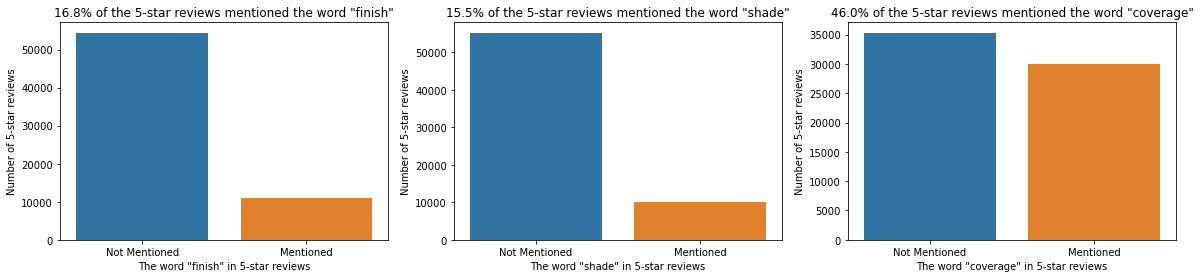

In [18]:
# hide_input
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
sns.countplot(x=all_data[all_data['rating']==5]['finish'], ax=ax1)
ax1.set_xlabel('The word "finish" in 5-star reviews')
ax1.set_ylabel('Number of 5-star reviews')
ax1.title.set_text('16.8% of the 5-star reviews mentioned the word "finish"')
ax1.set_xticklabels(labels=['Not Mentioned', 'Mentioned'])
# ax1.tick_params(axis='x', rotation=45)
# ax1.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#
sns.countplot(x=all_data[all_data['rating']==5]['shade_match'], ax=ax2)
ax2.set_xlabel('The word "shade" in 5-star reviews')
ax2.set_ylabel('Number of 5-star reviews')
ax2.title.set_text('15.5% of the 5-star reviews mentioned the word "shade"')
ax2.set_xticklabels(labels=['Not Mentioned', 'Mentioned'])
# ax2.title.set_text('49% say they are brunettes')
#
sns.countplot(x=all_data[all_data['rating']==5]['coverage'], ax=ax3)
ax3.set_xlabel('The word "coverage" in 5-star reviews')
ax3.set_ylabel('Number of 5-star reviews')
ax3.title.set_text('46.0% of the 5-star reviews mentioned the word "coverage"')
ax3.set_xticklabels(labels=['Not Mentioned', 'Mentioned'])
# ax3.set_xlabel('Self-reported eye colors')
# ax3.set_ylabel('Number of people')
# ax3.tick_params(axis='x', rotation=45)
# ax3.title.set_text('55% say they have brown eyes')


In [19]:
# hide
# sum(all_data[all_data['rating']==5]['finish']) / len(all_data[all_data['rating']==5])

In [20]:
# hide
# sum(all_data[all_data['rating']==5]['shade_match']) / len(all_data[all_data['rating']==5])

In [21]:
# hide
# sum(all_data[all_data['rating']==5]['coverage']) / len(all_data[all_data['rating']==5])

## Do people with different skin tones prefer different foundations?

It turns out that they do!

By skin tones:
+ People with light skins like NARS Natural Radiant Longwear Foundation and Smashbox Studio Skin 24 Hour Full Coverage Waterproof Foundation
+ People not having light skins like Fenty Beauty's Pro Filt'r Hydrating Longwear Founation and Marc Jacobs Beauty Re(marc)able Full Cover Foundation Concentrate



Text(0.5, 1.0, 'Top-5 Rated Foundations by People with Light Skins')

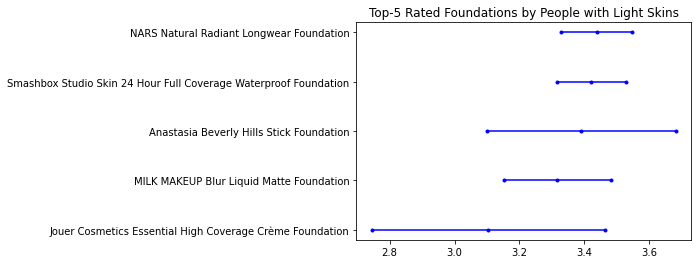

In [22]:
plot_diff_in_means(data = all_data[all_data['skin_tone'] == 'Light'], col1='brand_product', head=True)
plt.title("Top-5 Rated Foundations by People with Light Skins")


Text(0.5, 1.0, 'Top-5 Rated Foundations by People *Not* Having Light Skins')

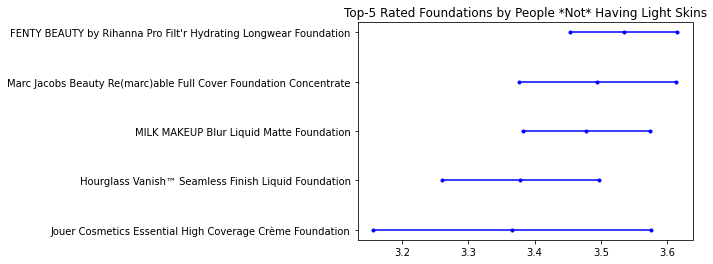

In [23]:
plot_diff_in_means(data = all_data[all_data['skin_tone'] != 'Light'], col1='brand_product', head=True)
plt.title("Top-5 Rated Foundations by People *Not* Having Light Skins")


## Appendix: Overall Rating for All Foundations

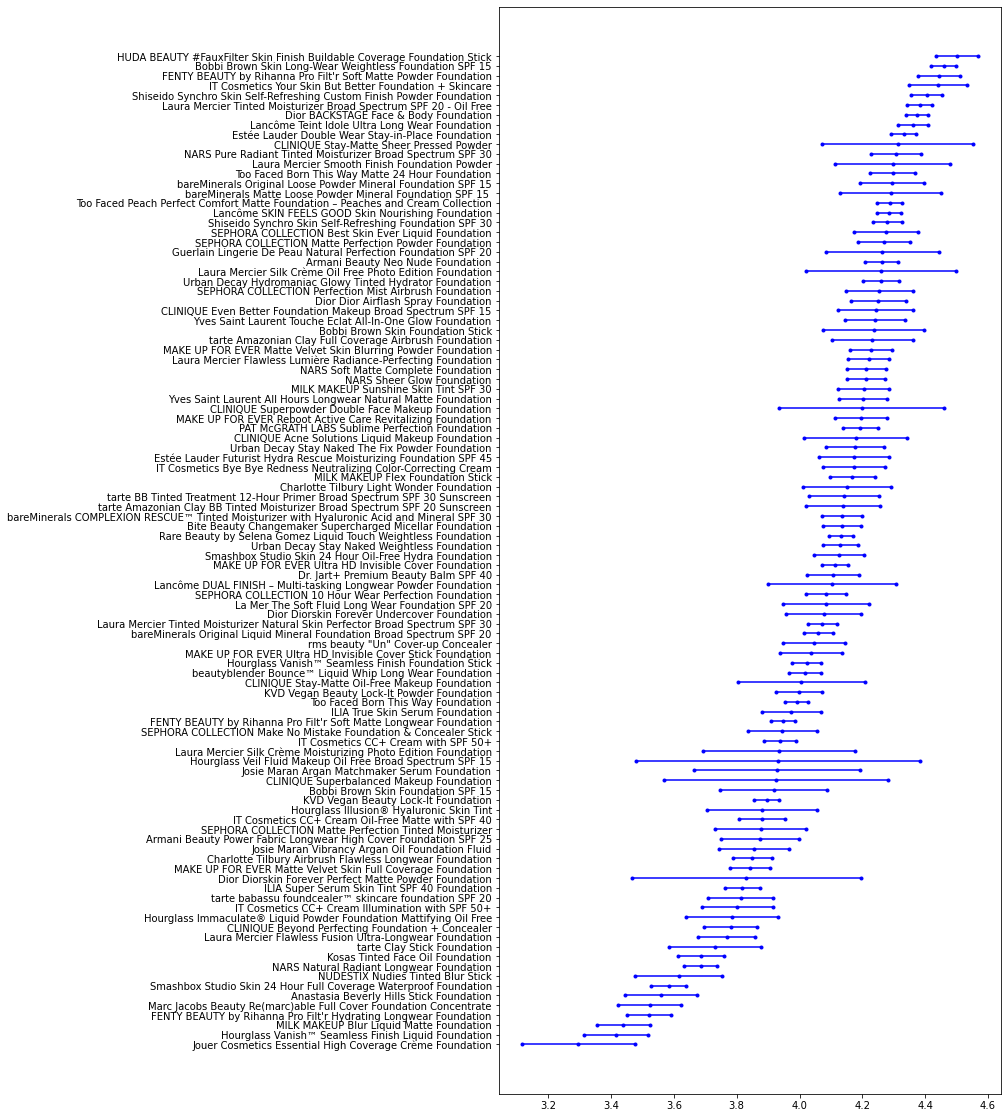

In [24]:
# hide_input
plt.figure(figsize=(9,20))
plot_diff_in_means(data = all_data, col1='brand_product', head=False)